<a href="https://colab.research.google.com/github/KeonhoChu/Train/blob/main/Cifar10_with_Alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Cifar10 with Alexnet

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt


from keras.datasets import cifar10,cifar100
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D
from keras.constraints import maxnorm #매개변수에 제약.ex)kernel_constraint: 주요 가중치 행렬에 대해서 제약.
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau,EarlyStopping
from keras.regularizers import L2
from keras import backend as K
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

import skimage
from skimage.util import img_as_ubyte

In [ ]:

os.getcwd()

'/content'

In [ ]:
#Defining Variables

#Data set information
DATASET = 'cifar-10'
#DATASET = 'cifar-100'
input_shape=(32,32,3)

if DATASET == 'cifar-10':
  num_classes = 10
elif DATASET == 'cifar-100':
  num_classes = 100

#Model Parameters

model_type = 'Alexnet'

epochs = 25
lrate = 0.01
decay = lrate/epochs #lrate *decay(1)*decay(2)
batch_size = 32

data_augmentation = True
flow_from_dir = False #cifar10->keras

subtract_mean = True #batch=32->mean->반영해달라.
seed = 7
np.random.seed(seed)
#현재 path ->content
validate_dir = os.path.join("data","test") #path를 data폴더에 test를 연결해주세요.
train_dir = os.path.join("data","train")#path를 data폴더에 train를 연결해주세요.

# Prepare model model saving directory.
#현재 디렉토리 : os.getcwd()
save_dir = os.path.join(os.getcwd(), 'saved_models') #content +saved_models

#model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
model_name = DATASET+'_'+'%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
print("Model Type: ",model_type)
print("Model File: ",filepath)

Model Type:  Alexnet
Model File:  /content/saved_models/cifar-10_Alexnet_model.{epoch:03d}.h5


In [ ]:
if flow_from_dir:
  if DATASET == 'cifar-10':
    %pip install cifar2png # CIFAR-10 또는 CIFAR-100 데이터 세트를 PNG 이미지로 변환합니다.
    %cifar2png cifar10 "data"

170498071/170498071 [==============================] - 4s 0us/step


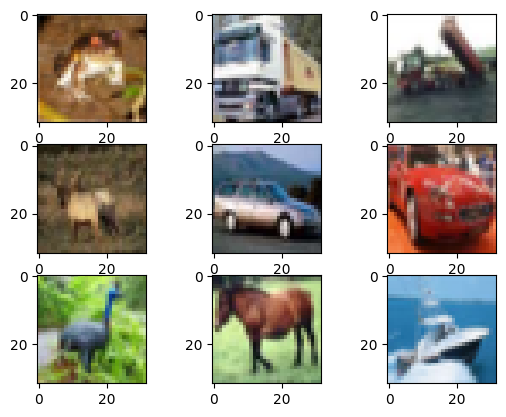

In [ ]:
if not flow_from_dir:
  #load data
  if DATASET == 'cifar-10':
    (X_train, y_train),(X_test,y_test) = cifar10.load_data()
    X_train.shape, X_test.shape, X_train.shape[1:],X_train.dtype
  elif DATASET == 'cifar-100':
    (X_train, y_train),(X_test,y_test) = cifar100.load_data()
    X_train.shape, X_test.shape, X_train.shape[1:],X_train.dtype

  #Plot data
  for i in range(0,9):
    plt.subplot(330+1+i)
    plt.imshow(X_train[i])
  plt.show()


In [ ]:

def convert_to_imagenet_size(images):
  tmp_images = []
  for image in images:
    image = skimage.transform.resize(image,(224,224),mode='constant')
    image = img_as_ubyte(image)
    tmp_images.append(image)
  return np.array(tmp_images)

In [ ]:
#Data Normalization
if not flow_from_dir: #True
  if not data_augmentation: #False
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train = X_train/255.
    X_test = X_test/255.

    if subtract_mean:
      X_train_mean = np.mean(X_train)
      X_train -= X_train_mean
      X_test_mean = np.mean(X_test)
      X_test -= X_test_mean

  print(y_train.shape, y_test.shape)

(50000, 1) (10000, 1)


In [ ]:

flow_from_dir

False

In [ ]:

if not data_augmentation: #False
    print('a')


In [ ]:
if not flow_from_dir: #True
    print('a')

a


In [ ]:

if not flow_from_dir:
  y_train = np_utils.to_categorical(y_train)
  y_test = np_utils.to_categorical(y_test)
  print(y_train.shape, y_test.shape)


(50000, 10) (10000, 10)


In [ ]:

#num_classes = y_train.shape[1]
#input_shape=X_train.shape[1:]

input_shape,num_classes

((32, 32, 3), 10)

In [ ]:
#Define Alexnet Model
def AlexnetModel(input_shape,num_classes):
  model = Sequential()
  model.add(Conv2D(filters=96,kernel_size=(3,3),strides=(4,4),input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(256,(5,5),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes,activation='softmax'))

  #model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

  #model.summary()
  return model

In [ ]:

def get_model(input_shape,num_classes):
  # Create the model - Normal model with CNN, dropouts and MaxPooling.
  # This model gives accuracy of 77% on the test set after 25 epochs

  model = Sequential()

  #model.add(Conv2D(32,(3,3),input_shape=(32,32,3),padding='same',activation='relu'))
  model.add(Conv2D(32,(3,3),input_shape=input_shape,padding='same',activation='relu'))
  model.add(Dropout(0.2))

  model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(Dropout(0.2))

  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
  model.add(Dropout(0.2))

  model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dropout(0.2))

  model.add(Dense(1024,activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(512,activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(num_classes,activation='softmax'))

  return model

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

#Earlystopping의 인자

- EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto') (-> default 값으로 구성)

- monitor : 학습 조기 종료를 위해 관찰하는 항목으로 val_loss(default)나 val_acc를 주로 사용한다.

- min_delta : 개선되고 있다고 판단하기 위한 최소 변화

- patience : 개선이 없어도 바로 종료하지 않고 그러한 epoch를 기다리는 횟수

- verbose : 얼마나 자세하게 정보를 표현할 것인지를 지정

- verbose=0 : Silent

- verbose=1 : progress bar

- verbose=2 : one line per epoch

- mode : monitor에 대해 개선이 없다고 판단하기 위한 기준. min은 monitor 항목이 감소가 멈출 때 종료, max는 증가가 멈출 때 종료, auto(default)는 관찰하는 이름에 따라 자동으로 설정

 ex) monitor = 'val_loss'인 경우에는 감소가 멈출 때 종료되어야 하므로 min으로 설정

 참고 : 출처: https://deep-deep-deep.tistory.com/56 [딥딥딥]

#ReduceLROnPlateau

모델의 개선이 없을 경우, Learning Rate를 조절해 모델의 개선을 유도하는 콜백함수

- monitor : ReduceLROnPlateau의 기준이 되는 값을 입력합니다. 만약 'val_loss'를 입력하면 val_loss가 더이상 감소되지 않을 경우 ReduceLROnPlateau을 적용합니다.

이외에도 다양한 값을 입력할 수 있습니다.

- factor : Learning rate를 얼마나 감소시킬 지 정하는 인자값입니다. 새로운 learning rate는 기존 learning rate * factor입니다. 예를 들어 현재 lr이 0.01이고 factor가 0.8일 때, 콜백함수가 실행된다면 그 다음 lr은 0.008이 됩니다. 또다른 예로 현재 lr이 0.3이고 factor가 0.1일 때, 콜백함수가 실행된다면 그 다음 lr은 0.03이 됩니다.

- patience : Training이 진행됨에도 더이상 monitor되는 값의 개선이 없을 경우, 최적의 monitor 값을 기준으로 몇 번의 epoch을 진행하고, learning rate를 조절할 지의 값입니다. 예시를 통해 이해하는 게 더 좋을 것 같습니다. 예를 들어 patience는 3이고, 30에폭에 정확도가 99%였을 때, 만약 31번째에 정확도 98%, 32번째에 98.5%, 33번째에 98%라면 모델의 개선이 (patience=3)동안 개선이 없었기에, ReduceLROnPlateau 콜백함수를 실행합니다.

- verbose : 얼마나 자세하게 정보를 표현할 것 인지를 지정

- verbose=0 : Silent
- verbose=1 : progress bar
- verbose=2 : one line per epoch
- mode : "auto" 또는 "min" 또는 "max" monitor되는 값이 최소가 되어야 하는지, 최대가 되어야 하는지 알려주는 인자입니다. 예를 들어, monitor하는 값이 val_acc 즉 정확도일 경우, 값이 클수록 좋기때문에 "max"를 입력하고, val_loss일 경우 작을수록 좋기 때문에 "min"을 입력합니다.

#"auto"는 모델이 알아서 판단합니다.

- min_delta : 개선된 것으로 간주하기 위한 최소한의 변화량입니다. 예를 들어, min_delta가 0.01이고, 30에폭에 정확도가 0.8532라고 할 때,
만약 31에폭에 정확도가 0.8537라고 하면 이는 0.005의 개선이 있었지만 min_delta 값 0.01에는 미치지 못했으므로 개선된 것으로 보지 않습니다.

- cooldown : Learning rate가 감소한 후, ReduceLROnPlateau 콜백함수를 다시 실행하기 전에 대기 할 Epoch 수입니다. 예시로 이해하는 게 좋을 것 같습니다. 예를 들어, factor가 3이고, cooldown이 5일 때, 만약 ReduceLROnPlateau이 적용되어 learning rate가 감소되었다고 합시다. 감소된 이후에도, 3에폭 연속 monitor 값의 개선이 없다고 해도, ReduceLROnPlateau는 실행되지 않습니다. cooldown이 적용되고 있기 때문입니다. cooldown 값인 5 에폭 실행 후, 3번 연속 moniort 값의 개선이 없을 시, ReduceLROnPlateau이 다시 적용됩니다.

- min_lr : Learning rate의 하한선을 지정합니다.b 예를 들어 현재 lr이 0.1이고 factor가 0.5이고, min_lr이 0.03이라면, 첫 번째로 콜백함수가 적용될 시, lr은 0.05(0.10.5)이 됩니다. 두 번째로 콜백함수가 적용된다면 0.025(0.10.5*0.5)이지만, min_lr이 0.03이기 때문에, 새로운 learning rate는 0.025가 아닌, 0.03이 됩니다.

In [ ]:
#Prepare callbacks for model saving and for learning rate adjustment.

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler,early_stopping]

#Adam
: 아담(Adam)은 Adaptive Moment Estimation의 약자입니다. 모멘텀과 RMSprop을 섞어놓은 최적화 알고리즘 입기 때문에, 딥러닝에서 가장 흔히 사용되는 최적화 알고리즘 입니다.

참고 : https://velog.io/@minjung-s/Optimization-Algorithm#:~:text=%EC%95%84%EB%8B%B4(Adam)%EC%9D%80%20Adaptive%20Moment,%EC%82%AC%EC%9A%A9%EB%90%98%EB%8A%94%20%EC%B5%9C%EC%A0%81%ED%99%94%20%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98%20%EC%9E%85%EB%8B%88%EB%8B%A4.

- lr: 0보다 크거나 같은 float 값. 학습률.
- beta_1: 0보다 크고 1보다 작은 float 값. 일반적으로 1에 가깝게 설정됩니다.
- beta_2: 0보다 크고 1보다 작은 float 값. 일반적으로 1에 가깝게 설정됩니다.
epsilon: 0보다 크거나 같은 float형 fuzz factor. None인 경우 K.epsilon()이 사용됩니다.
-decay: 0보다 크거나 같은 float 값. 업데이트마다 적용되는 학습률의  감소율입니다.
- amsgrad: 불리언. Adam의 변형인 AMSGrad의 적용 여부를 설정합니다. AMSGrad는 "On the Convergence of Adam and Beyond" 논문에서 소개되었습니다.

In [ ]:
#model = get_model(input_shape,num_classes)
if model_type == 'Alexnet':
  #input_shape = (224,224,3)
  model = AlexnetModel(input_shape,num_classes)
else:
  model = get_model(input_shape,num_classes)

# Compile model

# optimizer = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
#학습률을 줄이면서 학습하려면 위의 주석을 푸세요.
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss= 'categorical_crossentropy' , optimizer=optimizer, metrics=[ 'accuracy' ])
print("Model Summary of ",model_type)
print(model.summary())

Model Summary of  Alexnet
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 96)          2688      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 96)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 256)         614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (

- ImageDataGenerator : Noise 삽입, 색상, 밝기 변형 등을 활용하여 실시간으로 데이터 증강을 사용하고, 텐서 이미지 데이터 배치를 생성하여 데이터 학습의 정확도를 역할을 한다.

- 학습데이터를 조금씩 변형시켜서 학습데이터의 양을 늘리는 방식 중 하나.

- ZCA Whiteing 참고) https://ucsd.tistory.com/39#:~:text=%EB%A5%BC%20%EC%9D%98%EB%AF%B8%ED%95%A8)-,ZCA%20whitening,%EC%B0%A8%EC%9B%90%20%EA%B0%90%EC%86%8C%EB%8A%94%20%EC%9D%BC%EC%96%B4%EB%82%98%EC%A7%80%20%EC%95%8A%EB%8A%94%EB%8B%A4.

In [ ]:
if data_augmentation:
	print('Using real-time data augmentation.')
	# This will do preprocessing and realtime data augmentation:
	datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset / 불리언. 데이터셋에 대해 인풋의 평균이 0이 되도록 함.
        samplewise_center=False,  # set each sample mean to 0 / 불리언. 각 샘플의 평균이 0이 되도록 함.
        featurewise_std_normalization=True,  # divide inputs by std of the dataset / 불리언.인풋의 각 특성 내에서 데이터셋의 표준편차로 나눔.
        samplewise_std_normalization=False,  # divide each input by its std / 불리언. 각 인풋을 표준편차로 나눔.
        zca_whitening=False,  # apply ZCA whitening / zero-phase Componet Analysis / 불리언, 영위상 성분분석 백색화를 적용할지 여부. 참고 : https://withkairos.wordpress.com/2015/06/13/ufldl-tutorial-8-whitening/ㄴ
        zca_epsilon=1e-06,  # epsilon for ZCA whitening / 영위상 성분분석 백색화의 엡실론의 값 / 디폴트 값 : 1e-6
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180) / 랜덤하게 사진을 회전시킬 각도.
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.2, #부동소수점. 1D형태의 유사배열 혹은 정수. / # 수평으로 랜덤하게 평행이동 시킬 범위
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.2, # 수직으로 랜덤하게 평행이동 시킬 범위
        shear_range=0.,  # set range for random shear / 랜덤하게 전단 변환(shearing transformation)을 적용할 각도 범위
        zoom_range=0.,  # set range for random zoom / 무작위 줌 범위
        channel_shift_range=0.,  # set range for random channel shifts / 부동소수점. 무작위 채널의 이동의 범위.
        # set mode for filling points outside the input boundaries
        fill_mode='nearest', #회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀을 채울 전략.
        cval=0.,  # value used for fill_mode = "constant" / 부동소수점 혹은 정수/ fill_mode = 'constant'인 경우 경계 밖 공간에 사용하는 값.
        horizontal_flip=True,  # randomly flip images / #랜덤하게 이미지를 수평으로 뒤집는다. 수평 대칭을 가정할 수 잇을 때 사용(ex, 풍경/인물)
        vertical_flip=False,  # randomly flip images / 랜덤하게 이미지를 수직으로 뒤집는다.
        # set rescaling factor (applied before any other transformation)
        rescale=None, #크기 재조절 인수, 디폴트 값은 None / None 혹은 0인 경우 크기 재조절이 적용되지 않고, 그 외의 경우(다른 변형을 전부 적용한 후에) 데이터를 주어진 값으로 곱합.
        # set function that will be applied on each input
        preprocessing_function=None, #각 인풋에 적용되는 함수. 이미지가 크게 재조절되고 증강된 후에 함수가 작동.
        # image data format, either "channels_first" or "channels_last"
        data_format=None, # 이미지 데이터 형식, 'channel_first(B,C,W,H)'혹은 'channle_last'(B,W,H,C)가 사용가능.
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0) #부동소수점 / 검증의 용도로 남겨둘 이미지의 비율.

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).


if not flow_from_dir:
	if not data_augmentation:
		print('Not using data augmentation.')
		history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          shuffle=True,
          callbacks=callbacks)
	else:
		print("model using data from downloaded dataset in memoory")
		datagen.fit(X_train)
		# Fit the model on the batches generated by .datagenflow().
		history = model.fit_generator(datagen.flow(X_train, y_train,
                                 batch_size=batch_size),
                                 epochs=epochs,
                                 validation_data=datagen.flow((X_test, y_test),batch_size=batch_size),
                                 workers=4,
                                 callbacks=callbacks)

	scores = model.evaluate(X_test, y_test, verbose=1)

else:
	# generator for reading train data from folder

	print('Model fit using flow from directory')


	train_generator = datagen.flow_from_directory(
      train_dir,
      target_size = (224, 224),
      color_mode = 'rgb',
      batch_size = batch_size,
      class_mode = 'categorical',
      shuffle=False,
      seed=42
      )
	#
	# generator for reading validation data from folder

	validation_generator = datagen.flow_from_directory(
      validate_dir,
      target_size = (224, 224),
      color_mode = 'rgb',
      batch_size = batch_size,
      class_mode = 'categorical',
      shuffle=False,
      seed=42)

	STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
	STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

	history = model.fit_generator(generator=train_generator,
                steps_per_epoch=STEP_SIZE_TRAIN,
                validation_data=validation_generator,
                validation_steps=STEP_SIZE_VALID,
                epochs=10,
                callbacks=callbacks
                )

	scores = model.evaluate_generator(generator=validation_generator,
                           steps=STEP_SIZE_VALID, verbose=1)

	#Predict the output
	''' Use when to Predict the output
	STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
	test_generator.reset()
	pred=model.predict_generator(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)

	'''
# Save model and weights



# Score trained model.

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
model using data from downloaded dataset in memoory


<ipython-input-20-1a16394c1ab7>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train,


Learning rate:  0.001
Epoch 1/25
1560/1563 [============================>.] - ETA: 0s - loss: 1.1867 - accuracy: 0.5887

1563/1563 [==============================] - 65s 41ms/step - loss: 1.1872 - accuracy: 0.5885 - val_loss: 1.2010 - val_accuracy: 0.5712 - lr: 0.0010
Learning rate:  0.001
Epoch 2/25
1561/1563 [============================>.] - ETA: 0s - loss: 1.1781 - accuracy: 0.5877

1563/1563 [==============================] - 60s 38ms/step - loss: 1.1785 - accuracy: 0.5876 - val_loss: 1.1821 - val_accuracy: 0.5857 - lr: 0.0010
Learning rate:  0.001
Epoch 3/25
1563/1563 [==============================] - ETA: 0s - loss: 1.1808 - accuracy: 0.5889

1563/1563 [==============================] - 60s 38ms/step - loss: 1.1808 - accuracy: 0.5889 - val_loss: 1.1635 - val_accuracy: 0.5935 - lr: 0.0010
Learning rate:  0.001
Epoch 4/25
1562/1563 [============================>.] - ETA: 0s - loss: 1.1789 - accuracy: 0.5915

1563/1563 [==============================] - 59s 38ms/step - loss: 1.1787 - accuracy: 0.5915 - val_loss: 1.1911 - val_accuracy: 0.5818 - lr: 0.0010
Learning rate:  0.001
Epoch 5/25
1561/1563 [============================>.] - ETA: 0s - loss: 1.1708 - accuracy: 0.5924

1563/1563 [==============================] - 53s 34ms/step - loss: 1.1708 - accuracy: 0.5924 - val_loss: 1.1834 - val_accuracy: 0.5873 - lr: 0.0010
Learning rate:  0.001
Epoch 6/25
1562/1563 [============================>.] - ETA: 0s - loss: 1.1925 - accuracy: 0.5868

1563/1563 [==============================] - 59s 37ms/step - loss: 1.1925 - accuracy: 0.5868 - val_loss: 1.1685 - val_accuracy: 0.5847 - lr: 0.0010
Learning rate:  0.001
Epoch 7/25
1562/1563 [============================>.] - ETA: 0s - loss: 1.1917 - accuracy: 0.5859

1563/1563 [==============================] - 52s 33ms/step - loss: 1.1917 - accuracy: 0.5859 - val_loss: 1.1627 - val_accuracy: 0.5947 - lr: 0.0010
Learning rate:  0.001
Epoch 8/25
1561/1563 [============================>.] - ETA: 0s - loss: 1.1604 - accuracy: 0.5974

313/313 [==============================] - 2s 6ms/step - loss: 69.7835 - accuracy: 0.1687
Test loss: 69.78351593017578
Test accuracy: 0.16869999468326569


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


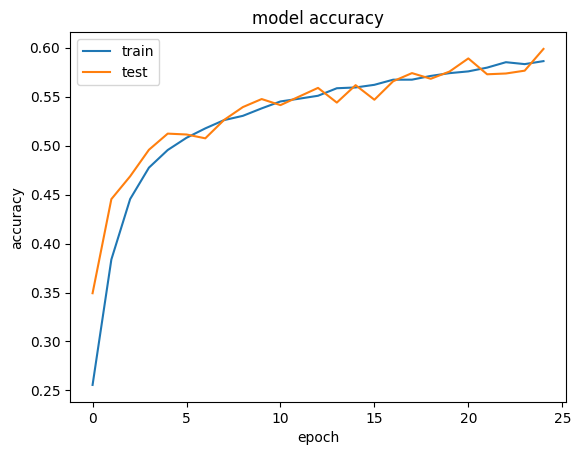

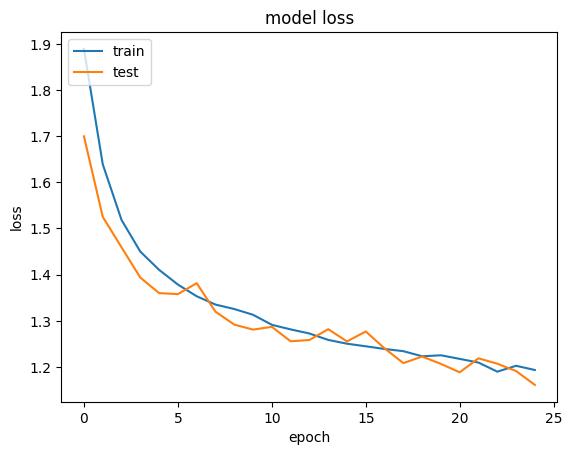

In [ ]:
|# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()